# Appliances Energy Prediction Dataset

URL: https://archive.ics.uci.edu/ml/datasets/Appliances+energy+prediction or https://www.kaggle.com/loveall/appliances-energy-prediction

Dataset description:

The dataset contains data from measurements taken within a low energy house, specifically temperature and humidity measurements by room, and outside weather data. Everything is presented as averages across ten minute intervalls of time and has previously been cleaned up by the datasets hosts - no missing or anomalous values, such as impossible or unreasonable temperatures, are present. The datasets purpose is to be able to predict the energy consumption of appliances in/of the house (recorded in the column "Appliances"). More information on the features of the dataset can be found in [description](#coldesc) below.

## Content

1) [Data exploration & preprocessing](#dataproc)

2) [Model training + evaluations](#train)
    
2.a) [Linear regression](#linear)

2.b) [Lasso Regression](#lasso)

2.c) [kNN](#knn)

2.d) [Random Forest](#rf)

---

<a id='dataproc'></a>

# 1) Data exploration & preprocessing


In [61]:
# Basic imports
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

# models for linear regression
from sklearn.linear_model import LinearRegression
from sklearn import linear_model

# models for Lasso regression
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV

# models for kNN
from sklearn import neighbors
from sklearn.metrics import mean_squared_error
from math import sqrt

# Imports for RandomForestRegressor
from sklearn.ensemble import RandomForestRegressor

# statistic tools
from sklearn import metrics
from statistics import stdev

# data processing
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

plot_dir = "./plots/energy/"

---

In [62]:
input_file = 'energydata_complete.csv'
df_raw = pd.read_csv(input_file,  sep = ',', header = 0)
df_raw

,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
0,2016-01-11 17:00:00,60,30,19.890000,47.596667,19.200000,44.790000,19.790000,44.730000,19.000000,...,17.033333,45.5300,6.600000,733.5,92.000000,7.000000,63.000000,5.300000,13.275433,13.275433
1,2016-01-11 17:10:00,60,30,19.890000,46.693333,19.200000,44.722500,19.790000,44.790000,19.000000,...,17.066667,45.5600,6.483333,733.6,92.000000,6.666667,59.166667,5.200000,18.606195,18.606195
2,2016-01-11 17:20:00,50,30,19.890000,46.300000,19.200000,44.626667,19.790000,44.933333,18.926667,...,17.000000,45.5000,6.366667,733.7,92.000000,6.333333,55.333333,5.100000,28.642668,28.642668
3,2016-01-11 17:30:00,50,40,19.890000,46.066667,19.200000,44.590000,19.790000,45.000000,18.890000,...,17.000000,45.4000,6.250000,733.8,92.000000,6.000000,51.500000,5.000000,45.410389,45.410389
4,2016-01-11 17:40:00,60,40,19.890000,46.333333,19.200000,44.530000,19.790000,45.000000,18.890000,...,17.000000,45.4000,6.133333,733.9,92.000000,5.666667,47.666667,4.900000,10.084097,10.084097
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19730,2016-05-27 17:20:00,100,0,25.566667,46.560000,25.890000,42.025714,27.200000,41.163333,24.700000,...,23.200000,46.7900,22.733333,755.2,55.666667,3.333333,23.666667,13.333333,43.096812,43.096812
19731,2016-05-27 17:30:00,90,0,25.500000,46.500000,25.754000,42.080000,27.133333,41.223333,24.700000,...,23.200000,46.7900,22.600000,755.2,56.000000,3.500000,24.500000,13.300000,49.282940,49.282940
19732,2016-05-27 17:40:00,270,10,25.500000,46.596667,25.628571,42.768571,27.050000,41.690000,24.700000,...,23.200000,46.7900,22.466667,755.2,56.333333,3.666667,25.333333,13.266667,29.199117,29.199117
19733,2016-05-27 17:50:00,420,10,25.500000,46.990000,25.414000,43.036000,26.890000,41.290000,24.700000,...,23.200000,46.8175,22.333333,755.2,56.666667,3.833333,26.166667,13.233333,6.322784,6.322784


In [63]:
display(df_raw.info())

print('Number of rows:' , df_raw.shape[0])
print('Number of columns in dataset is:' , df_raw.shape[1])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19735 entries, 0 to 19734
Data columns (total 29 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         19735 non-null  object 
 1   Appliances   19735 non-null  int64  
 2   lights       19735 non-null  int64  
 3   T1           19735 non-null  float64
 4   RH_1         19735 non-null  float64
 5   T2           19735 non-null  float64
 6   RH_2         19735 non-null  float64
 7   T3           19735 non-null  float64
 8   RH_3         19735 non-null  float64
 9   T4           19735 non-null  float64
 10  RH_4         19735 non-null  float64
 11  T5           19735 non-null  float64
 12  RH_5         19735 non-null  float64
 13  T6           19735 non-null  float64
 14  RH_6         19735 non-null  float64
 15  T7           19735 non-null  float64
 16  RH_7         19735 non-null  float64
 17  T8           19735 non-null  float64
 18  RH_8         19735 non-null  float64
 19  T9  

None

Number of rows: 19735
Number of columns in dataset is: 29


Some notes to take from this:
- quite high dimensional
- absolutely no missing values as far as pandas can tell...there might still be faulty, abnormally or otherwise problematic values
- essentially all values are numerical
- only the date column needs to be converted to datetime

In [64]:
df_raw['date'] = pd.to_datetime(df_raw['date'])
display(df_raw.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19735 entries, 0 to 19734
Data columns (total 29 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         19735 non-null  datetime64[ns]
 1   Appliances   19735 non-null  int64         
 2   lights       19735 non-null  int64         
 3   T1           19735 non-null  float64       
 4   RH_1         19735 non-null  float64       
 5   T2           19735 non-null  float64       
 6   RH_2         19735 non-null  float64       
 7   T3           19735 non-null  float64       
 8   RH_3         19735 non-null  float64       
 9   T4           19735 non-null  float64       
 10  RH_4         19735 non-null  float64       
 11  T5           19735 non-null  float64       
 12  RH_5         19735 non-null  float64       
 13  T6           19735 non-null  float64       
 14  RH_6         19735 non-null  float64       
 15  T7           19735 non-null  float64       
 16  RH_7

None

In [65]:
df_raw.describe()

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
count,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,...,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000
mean,97.694958,3.801875,21.686571,40.259739,20.341219,40.420420,22.267611,39.242500,20.855335,39.026904,...,19.485828,41.552401,7.411665,755.522602,79.750418,4.039752,38.330834,3.760707,24.988033,24.988033
std,102.524891,7.935988,1.606066,3.979299,2.192974,4.069813,2.006111,3.254576,2.042884,4.341321,...,2.014712,4.151497,5.317409,7.399441,14.901088,2.451221,11.794719,4.194648,14.496634,14.496634
min,10.000000,0.000000,16.790000,27.023333,16.100000,20.463333,17.200000,28.766667,15.100000,27.660000,...,14.890000,29.166667,-5.000000,729.300000,24.000000,0.000000,1.000000,-6.600000,0.005322,0.005322
25%,50.000000,0.000000,20.760000,37.333333,18.790000,37.900000,20.790000,36.900000,19.530000,35.530000,...,18.000000,38.500000,3.666667,750.933333,70.333333,2.000000,29.000000,0.900000,12.497889,12.497889
50%,60.000000,0.000000,21.600000,39.656667,20.000000,40.500000,22.100000,38.530000,20.666667,38.400000,...,19.390000,40.900000,6.916667,756.100000,83.666667,3.666667,40.000000,3.433333,24.897653,24.897653
75%,100.000000,0.000000,22.600000,43.066667,21.500000,43.260000,23.290000,41.760000,22.100000,42.156667,...,20.600000,44.338095,10.408333,760.933333,91.666667,5.500000,40.000000,6.566667,37.583769,37.583769
max,1080.000000,70.000000,26.260000,63.360000,29.856667,56.026667,29.236000,50.163333,26.200000,51.090000,...,24.500000,53.326667,26.100000,772.300000,100.000000,14.000000,66.000000,15.500000,49.996530,49.996530


<a id='coldesc'></a>
# Description of data columns

date time year-month-day hour:minute:second

Appliances, energy use in Wh

lights, energy use of light fixtures in the house in Wh

T1, Temperature in kitchen area, in Celsius

RH_1, Humidity in kitchen area, in %

T2, Temperature in living room area, in Celsius

RH_2, Humidity in living room area, in %

T3, Temperature in laundry room area

RH_3, Humidity in laundry room area, in %

T4, Temperature in office room, in Celsius

RH_4, Humidity in office room, in %

T5, Temperature in bathroom, in Celsius

RH_5, Humidity in bathroom, in %

T6, Temperature outside the building (north side), in Celsius

RH_6, Humidity outside the building (north side), in %

T7, Temperature in ironing room , in Celsius

RH_7, Humidity in ironing room, in %

T8, Temperature in teenager room 2, in Celsius

RH_8, Humidity in teenager room 2, in %

T9, Temperature in parents room, in Celsius

RH_9, Humidity in parents room, in %

To, Temperature outside (from Chievres weather station), in Celsius

Pressure (from Chievres weather station), in mm Hg

RH_out, Humidity outside (from Chievres weather station), in %

Wind speed (from Chievres weather station), in m/s

Visibility (from Chievres weather station), in km

Tdewpoint (from Chievres weather station), Â°C

rv1, Random variable 1, nondimensional

rv2, Random variable 2, nondimensional 

In [66]:
col_dict = {
    'date': 'time year-month-day hour:minute:second',
    'Appliances': 'energy use in Wh',
    'lights':' energy use of light fixtures in the house in Wh',
    'T1': 'Temperature in kitchen area: in Celsius',
    'RH_1':' Humidity in kitchen area: in %',
    'T2': 'Temperature in living room area: in Celsius',
    'RH_2':' Humidity in living room area: in %',
    'T3': 'Temperature in laundry room area',
    'RH_3': 'Humidity in laundry room area: in %',
    'T4': 'Temperature in office room: in Celsius',
    'RH_4': 'Humidity in office room: in %',
    'T5': 'Temperature in bathroom in Celsius',
    'RH_5': 'Humidity in bathroom in %',
    'T6': 'Temperature outside the building (north side: in Celsius',
    'RH_6': 'Humidity outside the building (north side): in %',
    'T7': 'Temperature in ironing room: in Celsius',
    'RH_7': 'Humidity in ironing room in %',
    'T8': 'Temperature in teenager room 2 in Celsius',
    'RH_8':' Humidity in teenager room 2 in %',
    'T9': 'Temperature in parents room in Celsius',
    'RH_9': 'Humidity in parents room: in %',
    'T_out': 'Temperature outside (from Chievres weather station): in Celsius',
    'Press_mm_hg': 'from Chievres weather station) in mm Hg',
    'RH_out': 'Humidity outside (from Chievres weather station): in %',
    'Windspeed': '(from Chievres weather station) in m/s',
    'Visibility': '(from Chievres weather station) in km',
    'Tdewpoint': '(from Chievres weather station) °C',
    'rv1': 'Random variable 1: nondimensional',
    'rv2': 'Random variable 2: nondimensional',
    "threshh": 'gives quartill of Appliance energy usage (0...<25%, 1...<50%, 2...<75%, 3...>75%)',
    "daytime": 'time of the day (extracted from date), as integer: (0...morning, 1...midday, 2...afternoon, 3...night)', 
    "daytime_str": 'same as daytime but with strings instead of integers',
}

# Divide amongst type of columns --> usefull for visualizations later
col_target = "Appliances"
col_light = "lights"
col_temp = ['T'+str(i) for i in range(1,10)]
col_hum = ['RH_'+str(i) for i in range(1,10)]
col_weather = ["T_out", "Tdewpoint","RH_out","Press_mm_hg","Windspeed","Visibility"] 
col_randoms = ["rv1", "rv2"]
col_threshh = "threshh"
col_datetime = ["date", "daytime", "daytime_str"]
col_visual = [col_threshh] + col_datetime
col_vars = col_temp + col_hum + col_weather + [col_light] 

In [67]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000): 
        with pd.option_context("display.max_columns", 1000): 
            display(df)

In [68]:
display_all(df_raw.tail().transpose())
print('#'*40)
display('Some more info')
print('#'*40)
display(df_raw.info())

,19730,19731,19732,19733,19734
date,2016-05-27 17:20:00,2016-05-27 17:30:00,2016-05-27 17:40:00,2016-05-27 17:50:00,2016-05-27 18:00:00
Appliances,100,90,270,420,430
lights,0,0,10,10,10
T1,25.5667,25.5,25.5,25.5,25.5
RH_1,46.56,46.5,46.5967,46.99,46.6
T2,25.89,25.754,25.6286,25.414,25.2643
RH_2,42.0257,42.08,42.7686,43.036,42.9714
T3,27.2,27.1333,27.05,26.89,26.8233
RH_3,41.1633,41.2233,41.69,41.29,41.1567
T4,24.7,24.7,24.7,24.7,24.7


########################################


'Some more info'

########################################
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19735 entries, 0 to 19734
Data columns (total 29 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         19735 non-null  datetime64[ns]
 1   Appliances   19735 non-null  int64         
 2   lights       19735 non-null  int64         
 3   T1           19735 non-null  float64       
 4   RH_1         19735 non-null  float64       
 5   T2           19735 non-null  float64       
 6   RH_2         19735 non-null  float64       
 7   T3           19735 non-null  float64       
 8   RH_3         19735 non-null  float64       
 9   T4           19735 non-null  float64       
 10  RH_4         19735 non-null  float64       
 11  T5           19735 non-null  float64       
 12  RH_5         19735 non-null  float64       
 13  T6           19735 non-null  float64       
 14  RH_6         19735 non-null  float64       
 15  T7          

None

In [69]:
# Data is aggregated into 10min intervalls
# One day = 24*6 instances
day = 24*6 #instances
print(f"Dataset contains roughly: {round(df_raw.shape[0]/day)} days of data")

Dataset contains roughly: 137 days of data


In [70]:
df_raw[0:int(137*day)]

,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
0,2016-01-11 17:00:00,60,30,19.890000,47.596667,19.2,44.790000,19.790000,44.730000,19.000000,...,17.033333,45.530000,6.600000,733.50,92.0,7.000000,63.000000,5.300000,13.275433,13.275433
1,2016-01-11 17:10:00,60,30,19.890000,46.693333,19.2,44.722500,19.790000,44.790000,19.000000,...,17.066667,45.560000,6.483333,733.60,92.0,6.666667,59.166667,5.200000,18.606195,18.606195
2,2016-01-11 17:20:00,50,30,19.890000,46.300000,19.2,44.626667,19.790000,44.933333,18.926667,...,17.000000,45.500000,6.366667,733.70,92.0,6.333333,55.333333,5.100000,28.642668,28.642668
3,2016-01-11 17:30:00,50,40,19.890000,46.066667,19.2,44.590000,19.790000,45.000000,18.890000,...,17.000000,45.400000,6.250000,733.80,92.0,6.000000,51.500000,5.000000,45.410389,45.410389
4,2016-01-11 17:40:00,60,40,19.890000,46.333333,19.2,44.530000,19.790000,45.000000,18.890000,...,17.000000,45.400000,6.133333,733.90,92.0,5.666667,47.666667,4.900000,10.084097,10.084097
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19723,2016-05-27 16:10:00,90,0,25.500000,45.790000,26.0,41.590000,28.100000,40.560000,24.700000,...,23.160000,46.590000,22.833333,755.45,55.0,2.166667,22.833333,13.233333,38.751594,38.751594
19724,2016-05-27 16:20:00,100,0,25.500000,45.933333,26.0,41.652857,28.000000,40.700000,24.700000,...,23.200000,46.621429,22.866667,755.40,55.0,2.333333,22.666667,13.266667,32.306224,32.306224
19725,2016-05-27 16:30:00,220,0,25.426667,46.060000,26.0,41.700000,28.000000,40.760000,24.700000,...,23.200000,46.700000,22.900000,755.35,55.0,2.500000,22.500000,13.300000,23.009520,23.009520
19726,2016-05-27 16:40:00,180,0,25.500000,46.530000,26.0,41.725714,27.856667,40.500000,24.700000,...,23.200000,46.652857,22.933333,755.30,55.0,2.666667,22.333333,13.333333,25.296732,25.296732


# Preprocessing

As we were working with the data, we decided to calculate additional features based on the existing data. Some were only used for visualization purposes, e.g. "threshh", while others, e.g. "daytime", were also later fed into the models.

Derived features:
- "threshh": We divided the appliance energy consumption into the 4 quartils and saved this information encoded as an integer [0,3] in this column. This quantity was only used for visualization purposes (for obvious reasons)! We hoped to get a clearer picture of the relation of various features to the target from this.
- "daytime" and "daytime_str": We calculated the time of day out of the date column based on the hour ([morning=6-12, midday=12-15, afternoon=15-20, night=rest]). The idea was that the energy consumption might be highly dependent on human behaviour aswell which (might) follow patterns that are repeated every day, such as morning routines, lunch, relaxing after work, etc.. We hoped to provide more (meaningful) context this way as oppossed to just inserting the raw datetime, also for visualization purposes. daytime and daytime_str simply differ in their encoding (integers vs strings). The strings were used for visualizations and integers for the models.

The preprocessing procedure is later gather into one function (see preprocess_EnergySet at the start of the next section)

In [71]:
# Functions used to calculate the derived quantities
def app_threshs(df_row):
    app = df_row['Appliances']
    if app < 50: # 25%
        threshh = 0
    elif app < 60: # 50%
        threshh = 1
    elif app < 100: # 75%-qart
        threshh = 2
    else:
        threshh = 3
    return threshh

def daytime(row):
    hour = row["date"].hour
    if 6 <= hour < 12:
        daytime = 0 # morning
    elif 12 <= hour < 15:
        daytime = 1 # midday
    elif 15 <= hour < 20:
        daytime = 2 # afternoon
    else:
        daytime = 3 # night
    return daytime

def daytime_str(row):
    hour = row["date"].hour
    if 6 <= hour < 12:
        daytime = "morning"
    elif 12 <= hour < 15:
        daytime = "'midday'"
    elif 15 <= hour < 20:
        daytime = "afternoon"
    else:
        daytime = "night"
    return daytime

In [155]:
vis = df_raw

In [156]:
vis['threshh'] = vis.apply(lambda row: app_threshs(row), axis=1)
vis.tail()

,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,...,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2,threshh,daytime
19730,2016-05-27 17:20:00,100,0,25.566667,46.560000,25.890000,42.025714,27.200000,41.163333,24.7,...,22.733333,755.2,55.666667,3.333333,23.666667,13.333333,43.096812,43.096812,3,2
19731,2016-05-27 17:30:00,90,0,25.500000,46.500000,25.754000,42.080000,27.133333,41.223333,24.7,...,22.600000,755.2,56.000000,3.500000,24.500000,13.300000,49.282940,49.282940,2,2
19732,2016-05-27 17:40:00,270,10,25.500000,46.596667,25.628571,42.768571,27.050000,41.690000,24.7,...,22.466667,755.2,56.333333,3.666667,25.333333,13.266667,29.199117,29.199117,3,2
19733,2016-05-27 17:50:00,420,10,25.500000,46.990000,25.414000,43.036000,26.890000,41.290000,24.7,...,22.333333,755.2,56.666667,3.833333,26.166667,13.233333,6.322784,6.322784,3,2
19734,2016-05-27 18:00:00,430,10,25.500000,46.600000,25.264286,42.971429,26.823333,41.156667,24.7,...,22.200000,755.2,57.000000,4.000000,27.000000,13.200000,34.118851,34.118851,3,2


In [157]:
vis['daytime'] = vis.apply(lambda row: daytime(row), axis=1)
display(vis.tail())

,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,...,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2,threshh,daytime
19730,2016-05-27 17:20:00,100,0,25.566667,46.560000,25.890000,42.025714,27.200000,41.163333,24.7,...,22.733333,755.2,55.666667,3.333333,23.666667,13.333333,43.096812,43.096812,3,2
19731,2016-05-27 17:30:00,90,0,25.500000,46.500000,25.754000,42.080000,27.133333,41.223333,24.7,...,22.600000,755.2,56.000000,3.500000,24.500000,13.300000,49.282940,49.282940,2,2
19732,2016-05-27 17:40:00,270,10,25.500000,46.596667,25.628571,42.768571,27.050000,41.690000,24.7,...,22.466667,755.2,56.333333,3.666667,25.333333,13.266667,29.199117,29.199117,3,2
19733,2016-05-27 17:50:00,420,10,25.500000,46.990000,25.414000,43.036000,26.890000,41.290000,24.7,...,22.333333,755.2,56.666667,3.833333,26.166667,13.233333,6.322784,6.322784,3,2
19734,2016-05-27 18:00:00,430,10,25.500000,46.600000,25.264286,42.971429,26.823333,41.156667,24.7,...,22.200000,755.2,57.000000,4.000000,27.000000,13.200000,34.118851,34.118851,3,2


In [158]:
vis['daytime_str'] = vis.apply(lambda row: daytime_str(row), axis=1)
display(vis.tail())

,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,...,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2,threshh,daytime,daytime_str
19730,2016-05-27 17:20:00,100,0,25.566667,46.560000,25.890000,42.025714,27.200000,41.163333,24.7,...,755.2,55.666667,3.333333,23.666667,13.333333,43.096812,43.096812,3,2,afternoon
19731,2016-05-27 17:30:00,90,0,25.500000,46.500000,25.754000,42.080000,27.133333,41.223333,24.7,...,755.2,56.000000,3.500000,24.500000,13.300000,49.282940,49.282940,2,2,afternoon
19732,2016-05-27 17:40:00,270,10,25.500000,46.596667,25.628571,42.768571,27.050000,41.690000,24.7,...,755.2,56.333333,3.666667,25.333333,13.266667,29.199117,29.199117,3,2,afternoon
19733,2016-05-27 17:50:00,420,10,25.500000,46.990000,25.414000,43.036000,26.890000,41.290000,24.7,...,755.2,56.666667,3.833333,26.166667,13.233333,6.322784,6.322784,3,2,afternoon
19734,2016-05-27 18:00:00,430,10,25.500000,46.600000,25.264286,42.971429,26.823333,41.156667,24.7,...,755.2,57.000000,4.000000,27.000000,13.200000,34.118851,34.118851,3,2,afternoon


In [159]:
vis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19735 entries, 0 to 19734
Data columns (total 32 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         19735 non-null  datetime64[ns]
 1   Appliances   19735 non-null  int64         
 2   lights       19735 non-null  int64         
 3   T1           19735 non-null  float64       
 4   RH_1         19735 non-null  float64       
 5   T2           19735 non-null  float64       
 6   RH_2         19735 non-null  float64       
 7   T3           19735 non-null  float64       
 8   RH_3         19735 non-null  float64       
 9   T4           19735 non-null  float64       
 10  RH_4         19735 non-null  float64       
 11  T5           19735 non-null  float64       
 12  RH_5         19735 non-null  float64       
 13  T6           19735 non-null  float64       
 14  RH_6         19735 non-null  float64       
 15  T7           19735 non-null  float64       
 16  RH_7

In [160]:
# Data is aggregated into 10min intervalls
# One day = 24*6 instances
day = 24*6 #instances
day

144

In [161]:
len(col_vars)

25

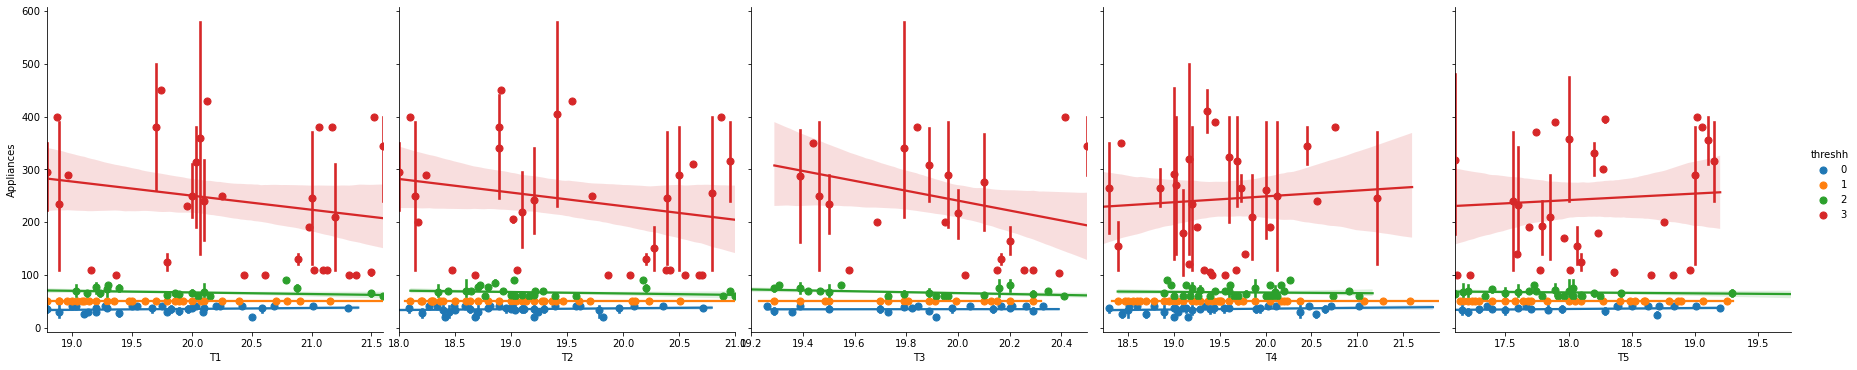

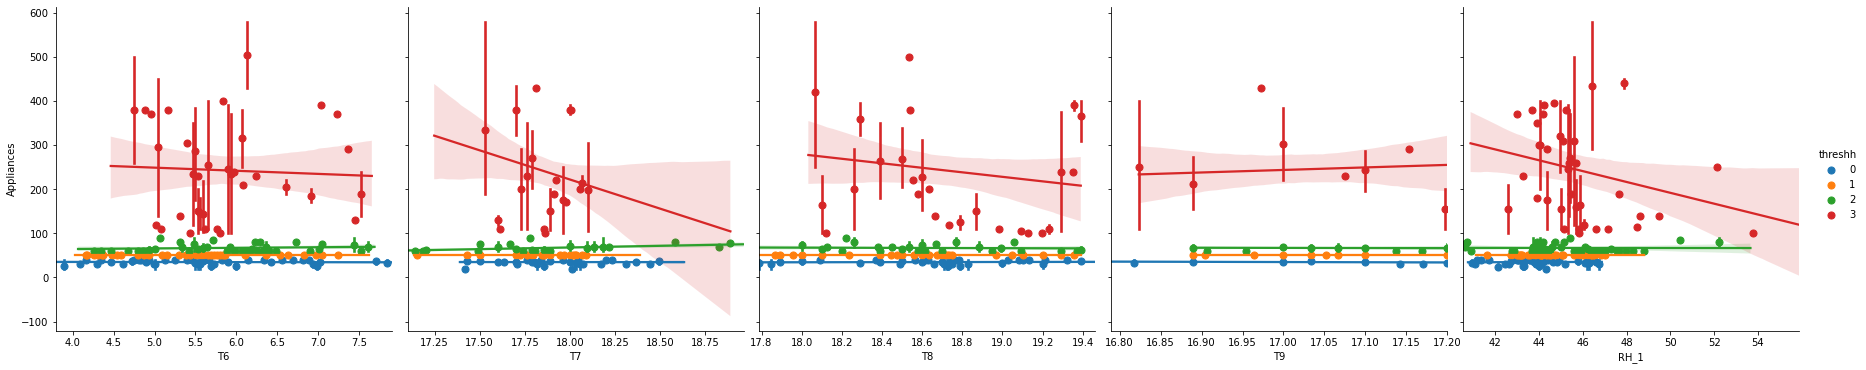

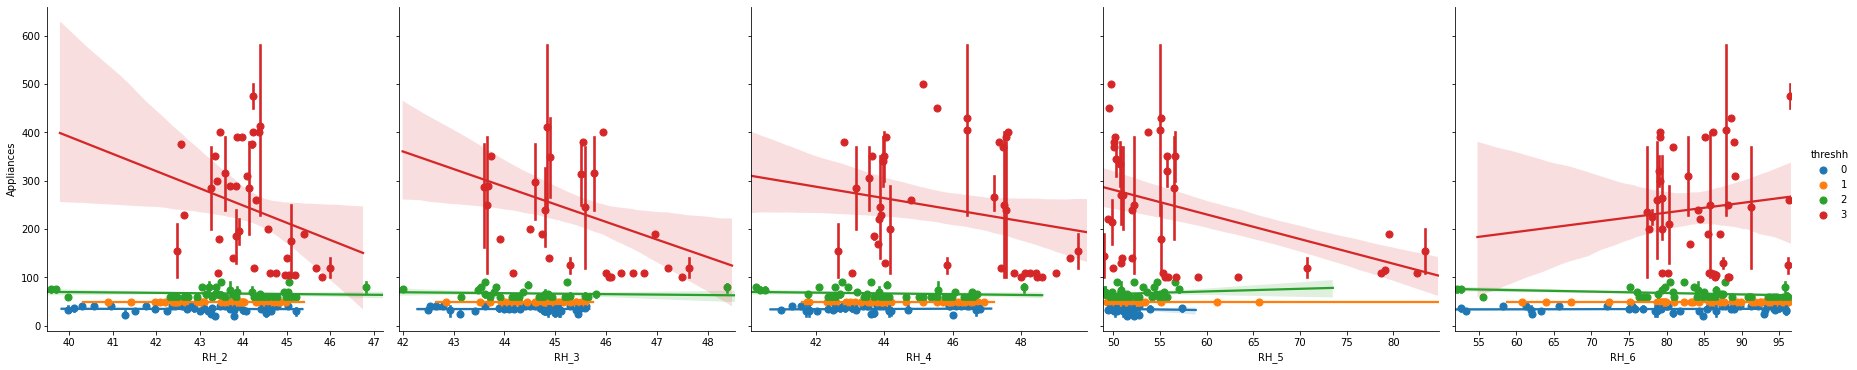

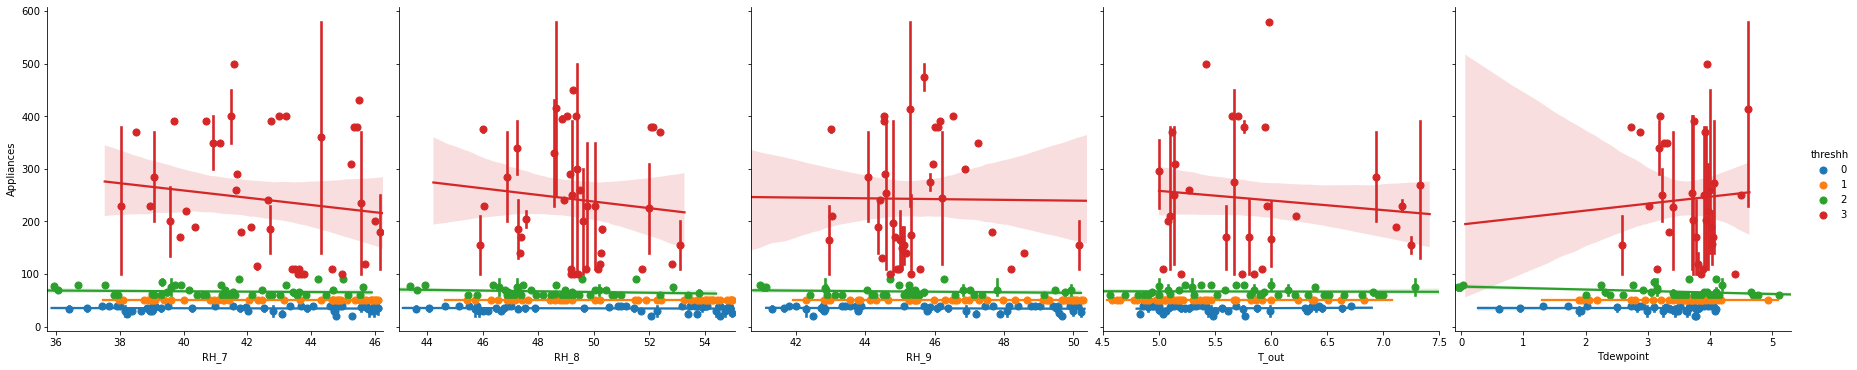

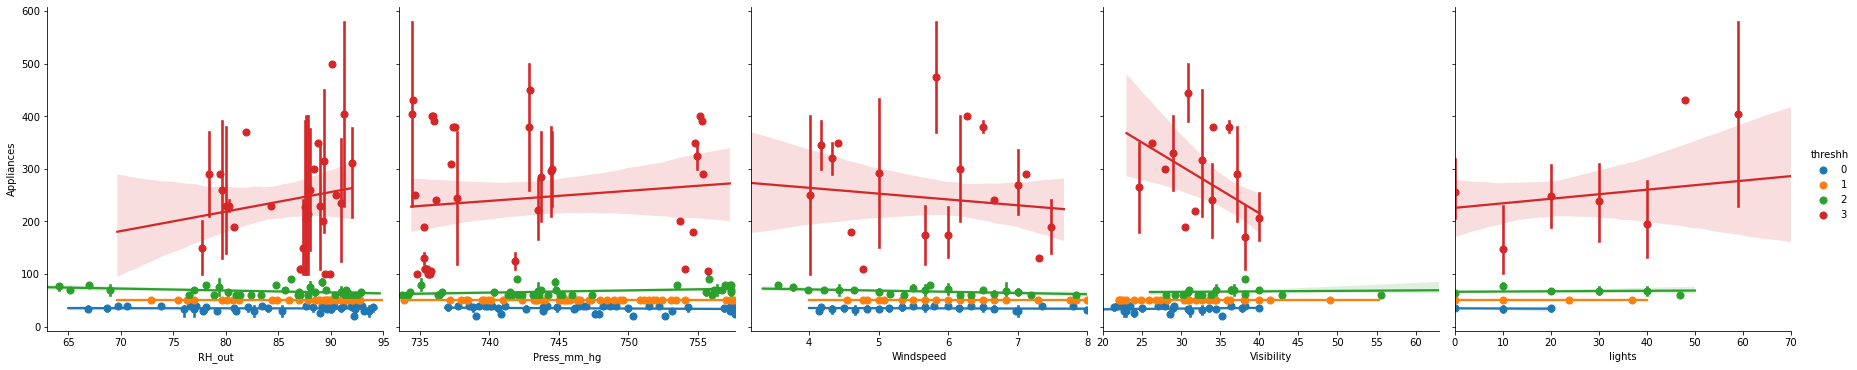

In [163]:
for i in range(5):
    g = sns.PairGrid(vis[:2*day],x_vars=col_vars[i*5:(i+1)*5], y_vars=[col_target], hue="threshh", height=5)
    g.map(sns.regplot)
    g.add_legend()
    g.savefig(plot_dir+f"regplot_lin_{i}.png")

C:\Dev\Python3.7\lib\site-packages\seaborn\axisgrid.py:98: UserWarning: The handle <matplotlib.patches.Patch object at 0x000002D4B2CDBE48> has a label of '_nolegend_' which cannot be automatically added to the legend.
  figlegend = self.fig.legend(handles, labels, **kwargs)
C:\Dev\Python3.7\lib\site-packages\seaborn\axisgrid.py:98: UserWarning: The handle <matplotlib.patches.Patch object at 0x000002D4B40DEEC8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  figlegend = self.fig.legend(handles, labels, **kwargs)
C:\Dev\Python3.7\lib\site-packages\seaborn\axisgrid.py:98: UserWarning: The handle <matplotlib.patches.Patch object at 0x000002D4B276C548> has a label of '_nolegend_' which cannot be automatically added to the legend.
  figlegend = self.fig.legend(handles, labels, **kwargs)
C:\Dev\Python3.7\lib\site-packages\seaborn\axisgrid.py:98: UserWarning: The handle <matplotlib.patches.Patch object at 0x000002D4B3132C88> has a label of '_nolegend_' which ca

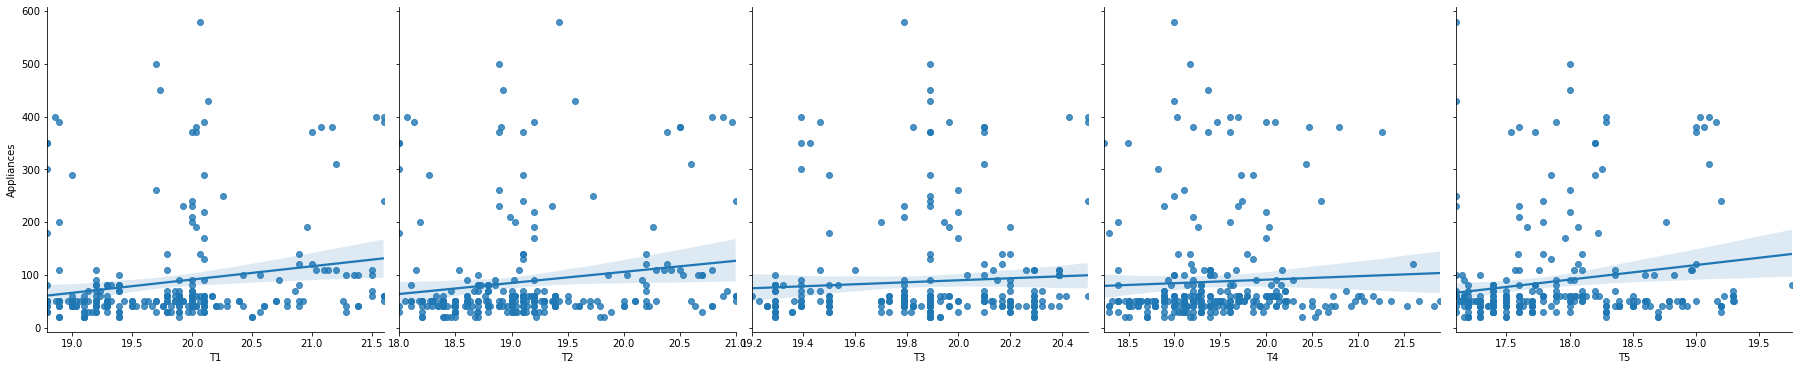

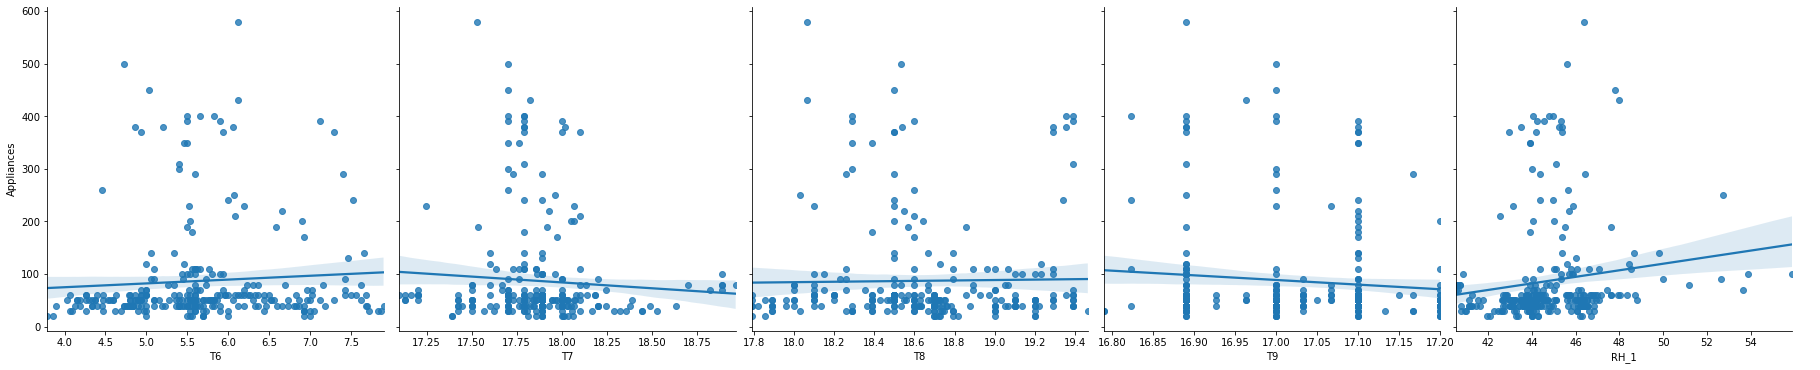

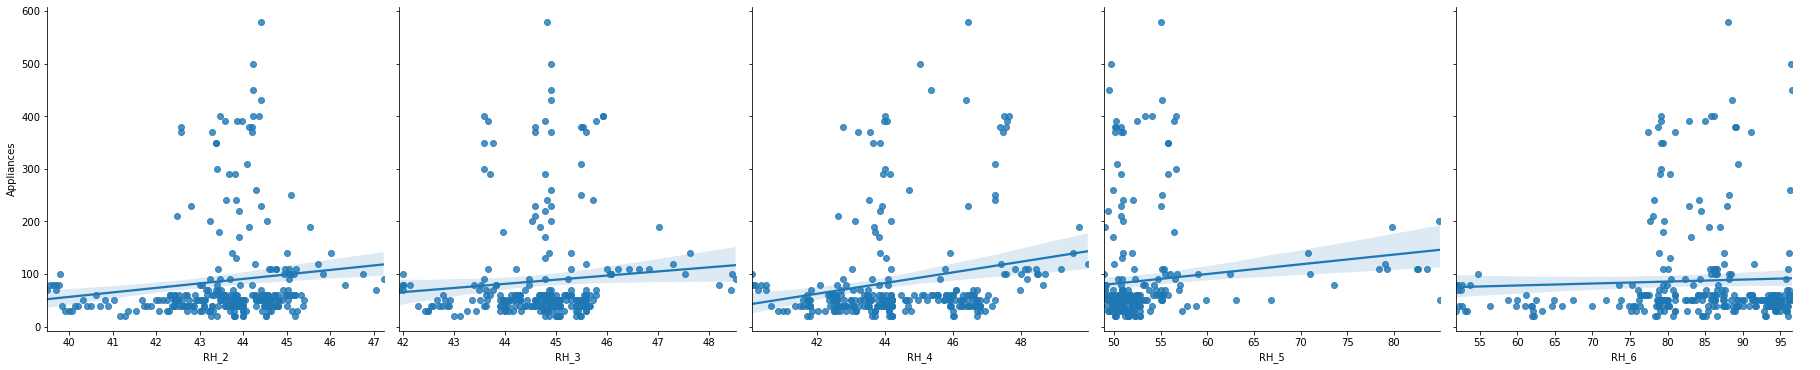

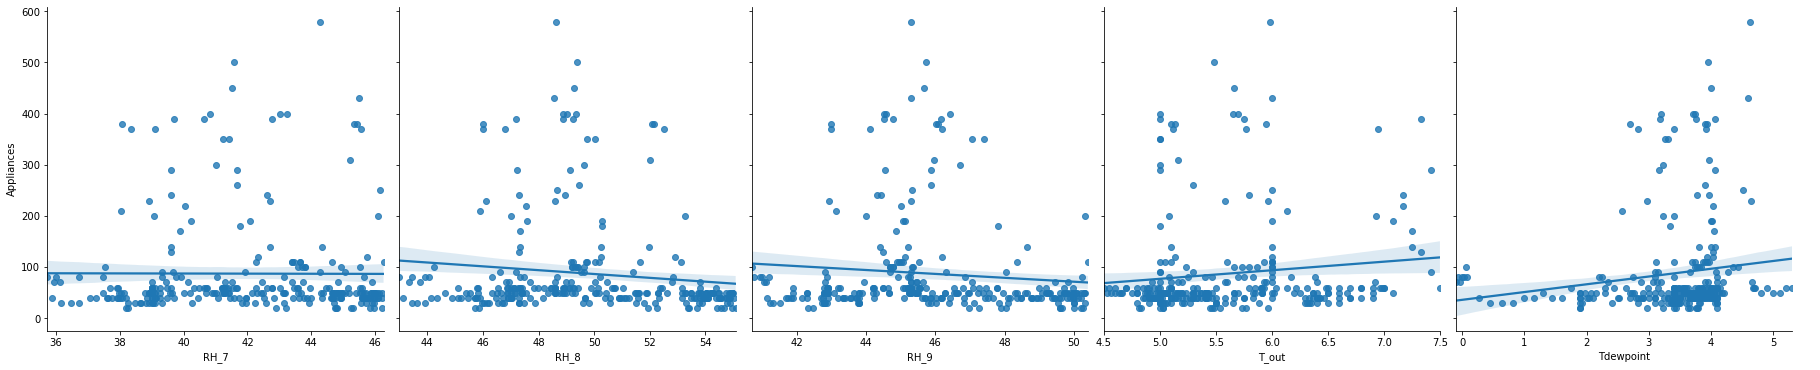

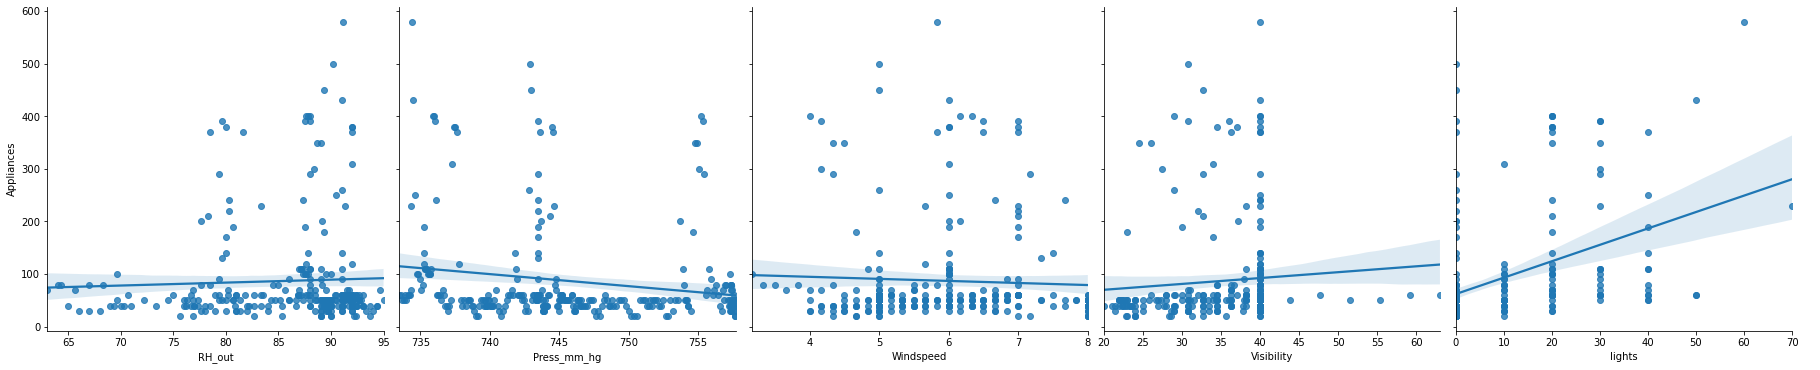

In [164]:
for i in range(5):
    g = sns.PairGrid(vis[:2*day],x_vars=col_vars[i*5:(i+1)*5], y_vars=[col_target], height=5)
    g.map(sns.regplot)
    g.add_legend()
    g.savefig(plot_dir+f"regplot_lin_{i}_noThreshh.png")

In [ ]:
# Indoor temperatures
for i in range(5):
    g = sns.PairGrid(vis[:],
                 x_vars=col_vars[i*5:(i+1)*5],
                 y_vars=[col_target], hue="threshh")
    g = g.map(sns.regplot, x_bins=10)
    g.add_legend()
   # Indoor temperatures
g.savefig(plot_dir+"regplot_lin_wthreshh.png")
display([f"{T}... {col_dict[T]}" for T in col_temp])

In [ ]:
# Indoor temperatures
for i in range(5):
    g = sns.PairGrid(vis[:],
                 x_vars=col_vars[i*5:(i+1)*5],
                 y_vars=[col_target], hue="daytime_str", palette="Set1")
    g = g.map(sns.regplot, x_bins=10)
    g.add_legend()
g.savefig
display([f"{T}... {col_dict[T]}" for T in col_temp])

In [ ]:
for i in range(2):
    g = sns.PairGrid(vis[:],
                 x_vars=col_weather[i*5:(i+1)*5],
                 y_vars=[col_target])
    g = g.map(sns.regplot, color='red', x_bins=10)

In [ ]:
# Compute correlations and save in matrix
corr = np.abs(vis.corr()) # We only used absolute values for visualization purposes! ..."hot-cold" view to just sort between 
# Mask the repeated values --> here: upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True # mask upper triangle
  
f, ax = plt.subplots(figsize=(18, 16))
sns.heatmap(corr, annot=True, fmt=".2f" , mask=mask, vmin=0, vmax=1, linewidths=.5, )
plt.show()

In [ ]:
# Compute correlations and save in matrix
corr = np.abs(vis.corr()) # We only used absolute values for visualization purposes! ..."hot-cold" view to just sort between 
# Mask the repeated values --> here: upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True # mask upper triangle
  
f, ax = plt.subplots(figsize=(18, 16))
sns.heatmap(corr, annot=True, fmt=".2f" , mask=mask, vmin=0, vmax=1, linewidths=.2, )
plt.savefig(plot_dir + "corr_map.png")
plt.show()

# Conclusion of heat map:

- All temperatures show at least some correlation to the target.
- Standout correlations: RH_out, T_out, lights, T6, T2 (>0.1) and daytime (derived) ...and obviously the derived column threshh (not used for models!)
- Temps and humidity of the same room correlate as expected
- T9 correlates highly to the other Ti
- T6 correlates considerably "well" with the target, but also correlates with T_out (0.97), with the other T_i and RH_6
- Visibility and Tdewpoint are not worth it (low corr with target + high corr with other features)
- The random variables do not correlate, as expected

We therefore decided to always drop:
['date', 'rv1', 'rv2', 'Visibility', 'Tdewpoint']

and created a second train/test set where we also drop:
['T6', 'T9']

to see if that has an impact on the accuracy...it will also speed up processing of the models!

<a id='train'></a>

# 2) Model training and evaluations
---

In [72]:
# Note that for the preprocess function we pass the raw data (df_raw), which does not include any added columns yet!
always_drop = ['date', 'rv1', 'rv2', 'Visibility', 'Tdewpoint']
add_drop = always_drop + ['T6', 'T9']
def preprocess_EnergySet(df_raw, split='random', seed=42, train_size=0.8, scale=True, addDaytime=True, drop=always_drop):
    display(df_raw.info())
    # Data is aggregated into 10min intervalls
    # One day = 24*6 instances
    day = 24*6 #instances
    days_in_set = int(round(df_raw.shape[0]/day,0))
    print(f"Dataset contains roughly: {days_in_set} days of data")
    df = df_raw.copy()
    #df['threshh'] = df.apply(lambda row: app_threshs(row), axis=1)
    if addDaytime:
        df['daytime'] = df.apply(lambda row: daytime(row), axis=1)
        #df['daytime_str'] = df.apply(lambda row: daytime_str(row), axis=1)
    print("Displaying DF before (optional) scaling and train/test splitting:")
    df = df.drop(drop, axis=1)
    display(df.info())
    print('Number of rows:' , df.shape[0])
    print('Number of columns in dataset is:' , df.shape[1])
    display(df.head())
    # 80%...training, 20%...testing
    if scale:
        sc=StandardScaler()
        df[df.columns] = sc.fit_transform(df)
    if split=='random':
        train, test = train_test_split(df,test_size=1-train_size,random_state=seed)
        return train, test
    elif split=='days':
        train, test = train_test_split(df,test_size=0.2, shuffle=False)
        return train, test
    else:
        return df

def xy_split(df, target="Appliances"):
    Y_train = df[target]
    X_train = df.drop(target, axis=1)
    return X_train, Y_train

In [73]:
import math
from sklearn.metrics import r2_score
def rmse(x,y): 
    return math.sqrt(((x-y)**2).mean())

def print_score(m, X_train, X_valid, y_train, y_valid, score=''):
    res = {
        'RMS(train)': rmse(m.predict(X_train), y_train),
        'RMS(test)': rmse(m.predict(X_valid), y_valid)}
    if score=='neg_mean_squared_error':
        r2tr = r2_score(y_train, m.predict(X_train))
        r2te = r2_score(y_valid, m.predict(X_valid))
    else:
        r2tr = m.score(X_train, y_train)
        r2te = m.score(X_valid, y_valid)
    res['R2(train)'] = r2tr
    res['R2(test)'] = r2te
    #if hasattr(m, 'oob_score_'): res['oob_score_'] = m.oob_score_
    display(res)
    return res

# Feature importance
from prettytable import PrettyTable as PT # pip install PTable
def print_RF_featureImportance(rf, X):
    table = PT()
    table.field_names = ['Feature', 'Score', 'Comment']
    sum = 0
    for name, score in zip(X.columns.values, rf.feature_importances_):
        print(f"{name}: {score:.5f}\t\t... {col_dict[name]}")
        table.add_row([name, round(score, ndigits=4), col_dict[name]])
        sum += score
    print(table)
    print(f"sum = {sum}")

def print_GridSearchResult(grid):
    print(grid.best_params_)
    print(grid.best_estimator_)

In [74]:
def comp_between_sets(Y_p1, Y_t1, Y_p2, Y_t2, title1="Train set 1", title2="Train set 2 (T6, T9) dropped", save='', ):
    f, (ax1, ax2) = plt.subplots(ncols=2,figsize=(16, 8))
    sns.distplot(Y_t1, ax=ax1)
    sns.distplot(Y_p1, color='red', ax=ax1)
    ax1.set_title(title1)

    sns.distplot(Y_t2, ax=ax2)
    sns.distplot(Y_p2, color='red', ax=ax2)
    ax2.set_title(title2)
    if save:
        f.savefig(save)

In [75]:
# Dictionary containing scores:
keys = ['linReg', 'lassoReg','kNN','randomForest']
vals = [0 for key in keys]
zipped = list(zip(keys, vals))
model_scores = dict(zipped)
model_scores2 = dict(zipped)
model_scores

{'linReg': 0, 'lassoReg': 0, 'kNN': 0, 'randomForest': 0}

In [76]:
# Dictionary containing the trained models:
keys = ['linReg', 'lassoReg','kNN','randomForest']
vals = [0 for key in keys]
zipped = list(zip(keys, vals))
models = dict(zipped)
models2 = dict(zipped)
models

{'linReg': 0, 'lassoReg': 0, 'kNN': 0, 'randomForest': 0}

In [154]:
train, test = preprocess_EnergySet(df_raw, split='random', train_size=0.8, scale=True)
train2, test2 = preprocess_EnergySet(df_raw, split='random', train_size=0.8, scale=True, drop=add_drop)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19735 entries, 0 to 19734
Data columns (total 31 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         19735 non-null  datetime64[ns]
 1   Appliances   19735 non-null  int64         
 2   lights       19735 non-null  int64         
 3   T1           19735 non-null  float64       
 4   RH_1         19735 non-null  float64       
 5   T2           19735 non-null  float64       
 6   RH_2         19735 non-null  float64       
 7   T3           19735 non-null  float64       
 8   RH_3         19735 non-null  float64       
 9   T4           19735 non-null  float64       
 10  RH_4         19735 non-null  float64       
 11  T5           19735 non-null  float64       
 12  RH_5         19735 non-null  float64       
 13  T6           19735 non-null  float64       
 14  RH_6         19735 non-null  float64       
 15  T7           19735 non-null  float64       
 16  RH_7

None

Dataset contains roughly: 137 days of data
Displaying DF before (optional) scaling and train/test splitting:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19735 entries, 0 to 19734
Data columns (total 26 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Appliances   19735 non-null  int64  
 1   lights       19735 non-null  int64  
 2   T1           19735 non-null  float64
 3   RH_1         19735 non-null  float64
 4   T2           19735 non-null  float64
 5   RH_2         19735 non-null  float64
 6   T3           19735 non-null  float64
 7   RH_3         19735 non-null  float64
 8   T4           19735 non-null  float64
 9   RH_4         19735 non-null  float64
 10  T5           19735 non-null  float64
 11  RH_5         19735 non-null  float64
 12  T6           19735 non-null  float64
 13  RH_6         19735 non-null  float64
 14  T7           19735 non-null  float64
 15  RH_7         19735 non-null  float64
 16  T8           19735 no

None

Number of rows: 19735
Number of columns in dataset is: 26


,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,...,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,threshh,daytime
0,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,45.566667,...,18.2,48.900000,17.033333,45.53,6.600000,733.5,92.0,7.000000,2,2
1,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,45.992500,...,18.2,48.863333,17.066667,45.56,6.483333,733.6,92.0,6.666667,2,2
2,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,45.890000,...,18.2,48.730000,17.000000,45.50,6.366667,733.7,92.0,6.333333,1,2
3,50,40,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,45.723333,...,18.1,48.590000,17.000000,45.40,6.250000,733.8,92.0,6.000000,1,2
4,60,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,45.530000,...,18.1,48.590000,17.000000,45.40,6.133333,733.9,92.0,5.666667,2,2


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19735 entries, 0 to 19734
Data columns (total 31 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         19735 non-null  datetime64[ns]
 1   Appliances   19735 non-null  int64         
 2   lights       19735 non-null  int64         
 3   T1           19735 non-null  float64       
 4   RH_1         19735 non-null  float64       
 5   T2           19735 non-null  float64       
 6   RH_2         19735 non-null  float64       
 7   T3           19735 non-null  float64       
 8   RH_3         19735 non-null  float64       
 9   T4           19735 non-null  float64       
 10  RH_4         19735 non-null  float64       
 11  T5           19735 non-null  float64       
 12  RH_5         19735 non-null  float64       
 13  T6           19735 non-null  float64       
 14  RH_6         19735 non-null  float64       
 15  T7           19735 non-null  float64       
 16  RH_7

None

Dataset contains roughly: 137 days of data
Displaying DF before (optional) scaling and train/test splitting:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19735 entries, 0 to 19734
Data columns (total 24 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Appliances   19735 non-null  int64  
 1   lights       19735 non-null  int64  
 2   T1           19735 non-null  float64
 3   RH_1         19735 non-null  float64
 4   T2           19735 non-null  float64
 5   RH_2         19735 non-null  float64
 6   T3           19735 non-null  float64
 7   RH_3         19735 non-null  float64
 8   T4           19735 non-null  float64
 9   RH_4         19735 non-null  float64
 10  T5           19735 non-null  float64
 11  RH_5         19735 non-null  float64
 12  RH_6         19735 non-null  float64
 13  T7           19735 non-null  float64
 14  RH_7         19735 non-null  float64
 15  T8           19735 non-null  float64
 16  RH_8         19735 no

None

Number of rows: 19735
Number of columns in dataset is: 24


,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,...,RH_7,T8,RH_8,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,threshh,daytime
0,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,45.566667,...,41.626667,18.2,48.900000,45.53,6.600000,733.5,92.0,7.000000,2,2
1,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,45.992500,...,41.560000,18.2,48.863333,45.56,6.483333,733.6,92.0,6.666667,2,2
2,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,45.890000,...,41.433333,18.2,48.730000,45.50,6.366667,733.7,92.0,6.333333,1,2
3,50,40,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,45.723333,...,41.290000,18.1,48.590000,45.40,6.250000,733.8,92.0,6.000000,1,2
4,60,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,45.530000,...,41.230000,18.1,48.590000,45.40,6.133333,733.9,92.0,5.666667,2,2


In [78]:
print(f"Target={col_target}")
X_train,Y_train = xy_split(train, target=col_target)
X_test,Y_test = xy_split(test, target=col_target)
X_train
print(f"Target={col_target}")
X_train2,Y_train2 = xy_split(train2, target=col_target)
X_test2,Y_test2 = xy_split(test2, target=col_target)
X_train2

Target=Appliances
Target=Appliances


,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,...,T7,RH_7,T8,RH_8,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,daytime
2133,-0.47908,-1.118645,1.316914,-0.520411,1.147399,-0.935970,1.550932,-0.859265,1.767501,-1.128170,...,-1.311462,1.586170,-2.002950,1.352130,1.721736,0.543199,0.861898,0.385860,1.411679,-0.646939
19730,-0.47908,2.415962,1.583299,2.530318,0.394449,2.458745,0.590209,1.882026,1.511812,1.955947,...,2.006168,1.781709,1.365409,1.366295,1.261649,2.881489,-0.043599,-1.616282,-0.288198,0.170171
3288,-0.47908,0.506486,1.048015,0.543620,0.533104,-0.151679,1.632358,0.560332,0.331650,-0.266786,...,-0.463097,-0.208874,-0.747626,-0.307233,0.958136,-0.152647,0.632145,-1.057025,1.615664,-0.646939
7730,-0.47908,-1.180910,-0.552810,-1.432438,0.126032,-0.831287,-0.638860,-1.206822,-0.466898,-0.705911,...,-1.027094,-0.662524,-0.781707,-0.066262,-0.199708,-0.998945,-1.890633,0.978673,-1.240129,-1.464050
8852,-0.47908,-0.676559,-1.248930,-1.478040,-0.154906,-0.985819,-0.689047,-0.663458,-1.042775,-0.754702,...,0.205169,-0.351618,0.342973,-0.703676,-0.352268,-1.556875,1.722345,0.844451,-0.968148,0.987281
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11284,-0.47908,0.045721,0.160902,-0.433769,0.655963,0.365088,-0.074512,0.315574,0.175780,0.275344,...,0.347353,-0.253848,1.092759,0.484378,-0.239053,0.405283,-0.683303,-0.139842,1.071703,0.987281
11964,-0.47908,0.437994,0.864561,0.756426,0.404512,0.215541,0.610694,0.212776,1.173197,0.058492,...,0.584326,0.913517,1.109800,0.777882,0.659441,1.859663,-0.813947,-0.922803,-0.832158,0.170171
5390,-0.47908,-0.869583,-1.145894,-0.976425,-0.695485,-1.080532,-0.507759,-1.299830,-0.860798,-0.592063,...,-0.837515,-1.053601,-0.393181,-0.236622,-0.502418,-1.594488,-0.084144,0.486526,-0.152208,0.987281
860,-0.47908,0.064400,-1.181077,0.042309,-1.303390,-0.532193,-0.719774,0.119768,-0.774800,-0.836022,...,0.721771,-0.899126,0.342973,-0.662522,-0.020652,-1.005214,1.285364,-1.034654,-1.104138,0.170171


<a id='linear'></a>

# a) Linear Regression

In [79]:
n_cores = 4
linreg = LinearRegression(normalize = True, n_jobs=n_cores)
linreg2 = LinearRegression(normalize = True, n_jobs=n_cores)
before = 0

In [80]:
linreg.fit(X_train,Y_train)
linreg2.fit(X_train2,Y_train2)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=4, normalize=True)

score:  0.1880996369544411
score2:  0.1773060931950019


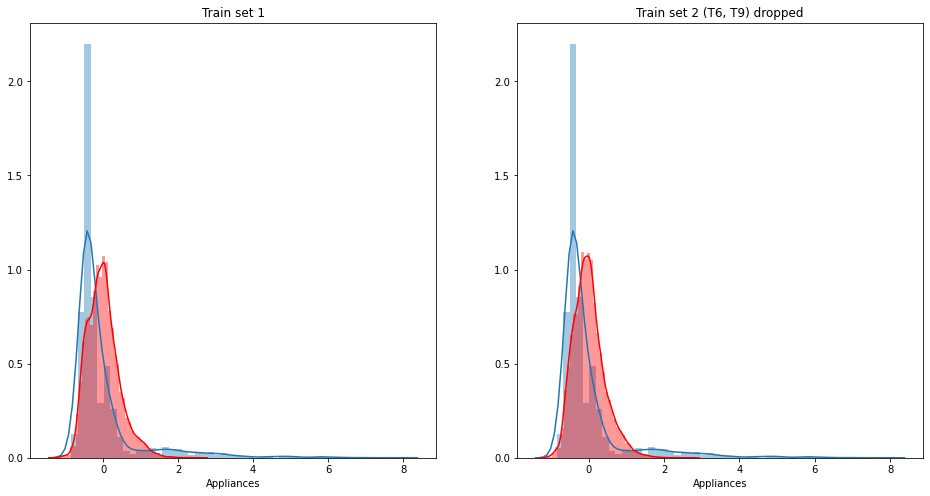

In [100]:
linreg.coef_
linreg2.coef_
score = linreg.score(X_test,Y_test)
print("score: ",score)
Y_lin_pred = linreg.predict(X_train)

score2 = linreg2.score(X_test2,Y_test2)
print("score2: ",score2)
Y_lin_pred2 = linreg2.predict(X_train2)
    
comp_between_sets(Y_lin_pred, Y_test, Y_lin_pred2, Y_test2, save=plot_dir+"dist_linReg_S1+2.png")

In [82]:
print("Before:")
display(before)#
print("Now:")
before = print_score(linreg, X_train, X_test, Y_train, Y_test)

Before:


0

Now:


{'RMS(train)': 0.9091848811402113,
 'RMS(test)': 0.8791985912456376,
 'R2(train)': 0.18314455200158364,
 'R2(test)': 0.1880996369544411}

In [83]:
# Save model + scores
model_scores['linReg'] = print_score(linreg, X_train, X_test, Y_train, Y_test)
models['linReg'] = linreg
model_scores2['linReg'] = print_score(linreg2, X_train2, X_test2, Y_train2, Y_test2)
models2['linReg'] = linreg2

{'RMS(train)': 0.9091848811402113,
 'RMS(test)': 0.8791985912456376,
 'R2(train)': 0.18314455200158364,
 'R2(test)': 0.1880996369544411}

{'RMS(train)': 0.9139791421466869,
 'RMS(test)': 0.8850234051599358,
 'R2(train)': 0.17450704891246993,
 'R2(test)': 0.1773060931950019}

<a id='lasso'></a>

# b) Lasso Regression

In [84]:
n_cores = 4
#lasso = Lasso(normalize = True)

# OR
# [1e-15,1e-10,1e-8,1e-3,1e-2,1,2,5,10,20,30,35,40,45,50,55,100]
# [1e-15,1e-8,1e-2,1,5,10,20,40,50,100]
parameters = {'alpha':[1e-15,1e-10,1e-7,1e-6,1e-3,1e-2,1,10,100,1000,1e6], 'max_iter':[100,1000,5000]}
lasso = GridSearchCV(Lasso(normalize = False),parameters,cv = 5, n_jobs=n_cores) 
lasso2 = GridSearchCV(Lasso(normalize = False),parameters,cv = 5, n_jobs=n_cores)

In [85]:
lasso.fit(X_train,Y_train)
lasso2.fit(X_train2,Y_train2)

GridSearchCV(cv=5, error_score=nan,
             estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=1000, normalize=False, positive=False,
                             precompute=False, random_state=None,
                             selection='cyclic', tol=0.0001, warm_start=False),
             iid='deprecated', n_jobs=4,
             param_grid={'alpha': [1e-15, 1e-10, 1e-07, 1e-06, 0.001, 0.01, 1,
                                   10, 100, 1000, 1000000.0],
                         'max_iter': [100, 1000, 5000]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [86]:
print(lasso.best_params_)
print(lasso.best_score_)
print(lasso2.best_params_)
print(lasso2.best_score_)

{'alpha': 1e-06, 'max_iter': 1000}
0.17997972470380164
{'alpha': 0.001, 'max_iter': 1000}
0.1716755405775484


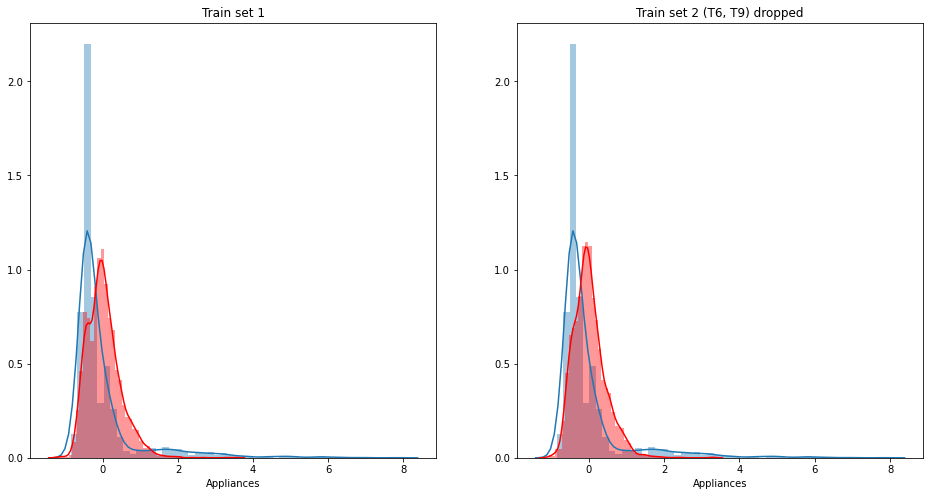

In [101]:
Y_lasso_pred = lasso.predict(X_test)
Y_lasso_pred2 = lasso2.predict(X_test2)
comp_between_sets(Y_lasso_pred, Y_test, Y_lasso_pred2, Y_test2, save=plot_dir+"dist_lassoReg_S1+2.png")

In [88]:
print("Before:")
display(before)#
print("Now:")
before = print_score(lasso, X_train, X_test, Y_train, Y_test)

Before:


{'RMS(train)': 0.9091848811402113,
 'RMS(test)': 0.8791985912456376,
 'R2(train)': 0.18314455200158364,
 'R2(test)': 0.1880996369544411}

Now:


{'RMS(train)': 0.9091848814383682,
 'RMS(test)': 0.8791979841629626,
 'R2(train)': 0.18314455146582664,
 'R2(test)': 0.1881007581811559}

In [89]:
# Save model scores
model_scores['lassoReg'] = print_score(lasso, X_train, X_test, Y_train, Y_test)
models['lassoReg'] = lasso
model_scores2['lassoReg'] = print_score(lasso2, X_train2, X_test2, Y_train2, Y_test2)
models2['lassoReg'] = lasso2

{'RMS(train)': 0.9091848814383682,
 'RMS(test)': 0.8791979841629626,
 'R2(train)': 0.18314455146582664,
 'R2(test)': 0.1881007581811559}

{'RMS(train)': 0.9141571652481613,
 'RMS(test)': 0.8849649460754818,
 'R2(train)': 0.17418544173216655,
 'R2(test)': 0.17741477358448254}

# Comparison Linear Regression model vs Lasso Regression

As expected, the Lasso regression is not able fit a better model than the linear regression, since it is just a modified version of the linear regression.

The Lasso model is actually slightly worse than a standard linear regression - this is most likely due to the implementation of the model in scikit-learn. It is noted in the documenation that one should not use the LassoRegressor with very small alphas and simply use the LinearRegressor instead.

In [90]:
print("Linear regression scores:")
display(model_scores['linReg'])
print("-"*40)
print("Lasso regression scores:")
display(model_scores2['lassoReg'])

Linear regression scores:


{'RMS(train)': 0.9091848811402113,
 'RMS(test)': 0.8791985912456376,
 'R2(train)': 0.18314455200158364,
 'R2(test)': 0.1880996369544411}

----------------------------------------
Lasso regression scores:


{'RMS(train)': 0.9141571652481613,
 'RMS(test)': 0.8849649460754818,
 'R2(train)': 0.17418544173216655,
 'R2(test)': 0.17741477358448254}

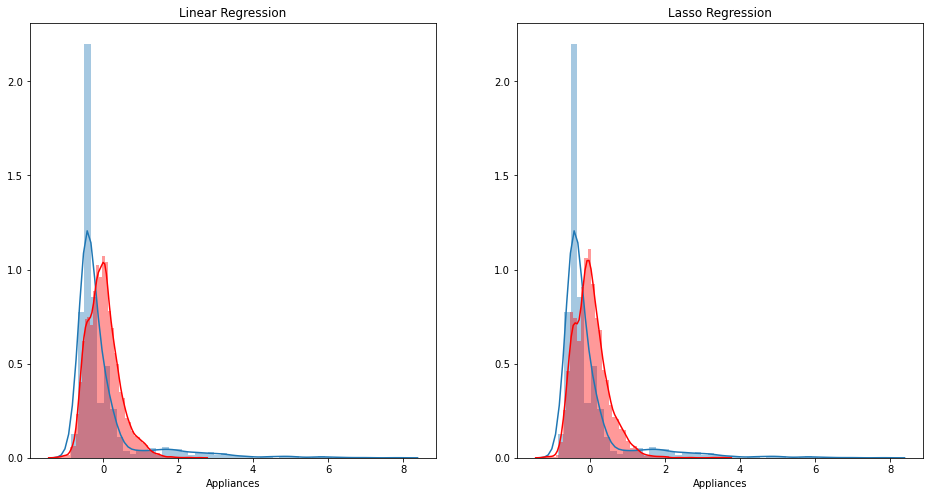

In [102]:
comp_between_sets(Y_lin_pred, Y_test, Y_lasso_pred, Y_test, title1="Linear Regression", title2="Lasso Regression", save=plot_dir+"dist_lassoReg_vs_linReg.png")

<a id='knn'></a>

# c) kNN

In [92]:
n_cores = 4
rmse_val_knn = [] # to store rmse values for different k
kmax = 25
ks = [k for k in range(1,kmax+1)]
besterror = 1
for k in ks:
    model = neighbors.KNeighborsRegressor(n_neighbors=k, n_jobs=n_cores)
    model.fit(X_train,Y_train)
    pred = model.predict(X_test)
    error = sqrt(mean_squared_error(Y_test, pred))
    rmse_val_knn.append(error)
    print("RMSE for k={}: {}".format(k, error))
    print("R^2 for k={}: {}\n".format(k, model.score(X_test, Y_test)))
    if error < besterror:
        besterror = error
        bestmodel = model
kNN = bestmodel

RMSE for k=1: 0.7818102194731503
R^2 for k=1: 0.35800528249648866

RMSE for k=2: 0.6941401902798184
R^2 for k=2: 0.49391536797945856

RMSE for k=3: 0.7074882086862376
R^2 for k=3: 0.4742646486031933

RMSE for k=4: 0.7127791224330926
R^2 for k=4: 0.4663718767793782

RMSE for k=5: 0.7238545775066119
R^2 for k=5: 0.44965957004524193

RMSE for k=6: 0.742481954482843
R^2 for k=6: 0.4209706548347929

RMSE for k=7: 0.7517530371992719
R^2 for k=7: 0.40642014781505154

RMSE for k=8: 0.7540309439881934
R^2 for k=8: 0.4028174536995148

RMSE for k=9: 0.7582092730545221
R^2 for k=9: 0.39618075361307814

RMSE for k=10: 0.7634968113502733
R^2 for k=10: 0.3877296569052098

RMSE for k=11: 0.7687199242035564
R^2 for k=11: 0.379323869930001

RMSE for k=12: 0.7706657423934092
R^2 for k=12: 0.3761777268761034

RMSE for k=13: 0.7711029162519558
R^2 for k=13: 0.3754697775603977

RMSE for k=14: 0.7732016991708511
R^2 for k=14: 0.3720654663185896

RMSE for k=15: 0.7752180129246228
R^2 for k=15: 0.3687862084256

In [93]:
n_cores = 4
rmse_val_knn2 = [] # to store rmse values for different k
kmax = 25
ks = [k for k in range(1,kmax+1)]
besterror = 1
for k in ks:
    model = neighbors.KNeighborsRegressor(n_neighbors=k, n_jobs=n_cores)
    model.fit(X_train2,Y_train2)
    pred = model.predict(X_test2)
    error = sqrt(mean_squared_error(Y_test2, pred))
    rmse_val_knn2.append(error)
    print("RMSE for k={}: {}".format(k, error))
    print("R^2 for k={}: {}\n".format(k, model.score(X_test2, Y_test2)))
    if error < besterror:
        besterror = error
        bestmodel = model
kNN2 = bestmodel

RMSE for k=1: 0.792459353296839
R^2 for k=1: 0.34039679088557695

RMSE for k=2: 0.6941093706750856
R^2 for k=2: 0.4939603069767402

RMSE for k=3: 0.7070699657203635
R^2 for k=3: 0.4748860585875131

RMSE for k=4: 0.713157143924124
R^2 for k=4: 0.4658057087079921

RMSE for k=5: 0.7260328530768487
R^2 for k=5: 0.4463423378312547

RMSE for k=6: 0.7422476762566246
R^2 for k=6: 0.42133600395979764

RMSE for k=7: 0.7527363411864649
R^2 for k=7: 0.4048663099705556

RMSE for k=8: 0.753676097466208
R^2 for k=8: 0.4033793889604175

RMSE for k=9: 0.7601361785874372
R^2 for k=9: 0.3931077732494943

RMSE for k=10: 0.764732449499547
R^2 for k=10: 0.38574626476603113

RMSE for k=11: 0.7692369259186133
R^2 for k=11: 0.37848871912683546

RMSE for k=12: 0.7728051205770308
R^2 for k=12: 0.3727094419630531

RMSE for k=13: 0.7721909919636375
R^2 for k=13: 0.3737060295924146

RMSE for k=14: 0.7727396812612771
R^2 for k=14: 0.3728156724364746

RMSE for k=15: 0.7760084609075147
R^2 for k=15: 0.3674983228709831

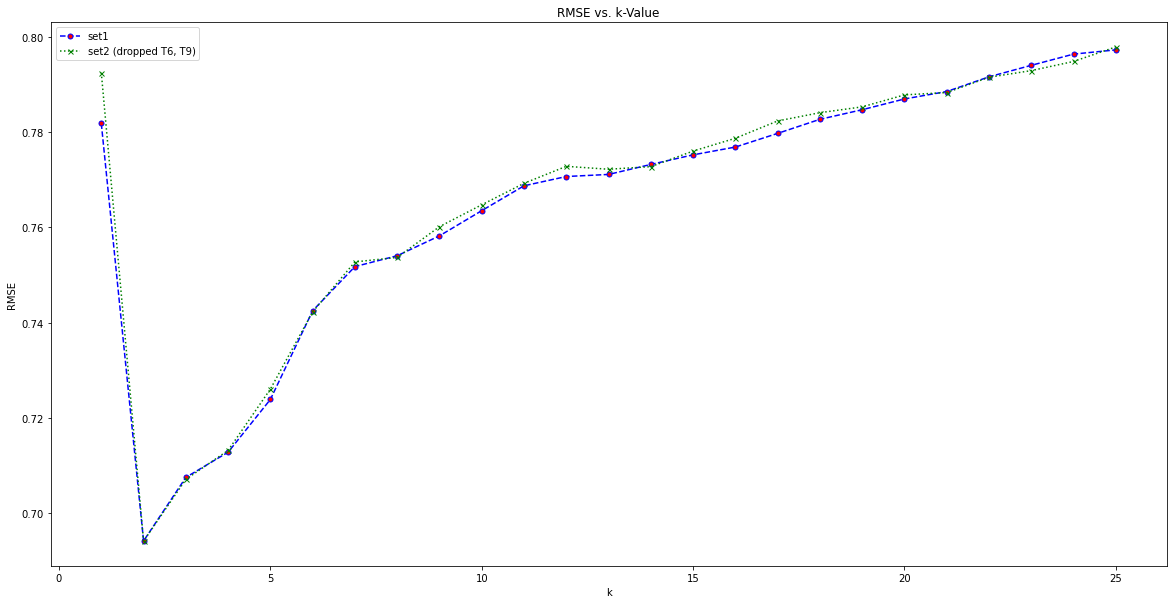

In [98]:
plt.figure(figsize=(20,10))
plt.plot(ks, rmse_val_knn, color='blue', linestyle='dashed', marker='o',
        markerfacecolor='red', markersize=5, label='set1')
plt.plot(ks, rmse_val_knn2, color='green', linestyle='dotted', marker='x',
        markerfacecolor='red', markersize=5, label='set2 (dropped T6, T9)')
plt.title('RMSE vs. k-Value')
plt.xlabel('k')
plt.ylabel('RMSE')
plt.legend()
plt.savefig(plot_dir+"rmse_vs_knn.png")

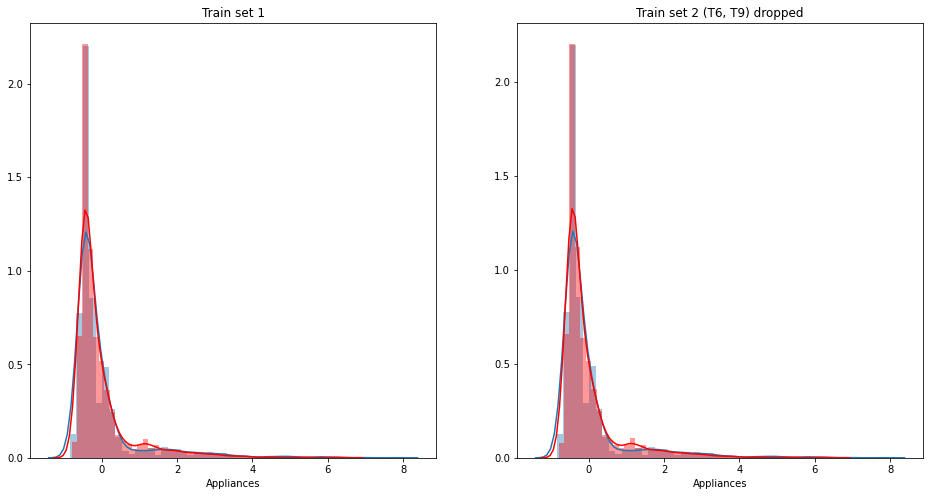

In [99]:
Y_kNN_pred = kNN.predict(X_test)
Y_kNN_pred2 = kNN2.predict(X_test2)
comp_between_sets(Y_kNN_pred, Y_test, Y_kNN_pred2, Y_test2, save=plot_dir+"dist_kNNReg_S1+2.png")

In [95]:
print("Before:")
display(before)#
print("Now:")
before = print_score(kNN, X_train, X_test, Y_train, Y_test)

Before:


{'RMS(train)': 0.9091848814383682,
 'RMS(test)': 0.8791979841629626,
 'R2(train)': 0.18314455146582664,
 'R2(test)': 0.1881007581811559}

Now:


{'RMS(train)': 0.4042780730865147,
 'RMS(test)': 0.6941401902798184,
 'R2(train)': 0.8384893467936548,
 'R2(test)': 0.49391536797945856}

In [97]:
# Save models + scores
kNN_dict = dict()
kNN_dict['p2_k2'] = print_score(kNN, X_train, X_test, Y_train, Y_test)
model_scores['kNN'] = kNN_dict

kNN_models = dict()
kNN_models['p2_k2'] = kNN
models['kNN'] = kNN_models

# Save models + scores 2
model_scores2['kNN'] = print_score(kNN2, X_train2, X_test2, Y_train2, Y_test2)
models2['kNN'] = kNN2

{'RMS(train)': 0.4042780730865147,
 'RMS(test)': 0.6941401902798184,
 'R2(train)': 0.8384893467936548,
 'R2(test)': 0.49391536797945856}

{'RMS(train)': 0.4038681413373249,
 'RMS(test)': 0.6941093706750856,
 'R2(train)': 0.8388167193714194,
 'R2(test)': 0.4939603069767402}

<a id='rf'></a>

# d) Random Forest

In [103]:
before = 0

In [104]:
from numpy import sqrt
num_features = X_train.shape[1]
print(num_features)
sqrt_num_features = int(round(sqrt(num_features), 0))
sqrt_num_features

24


5

In [105]:
# Simple training of RFRegressor
n_cores = 4
rf = RandomForestRegressor(n_jobs=n_cores, n_estimators=500, max_features=0.5, min_samples_leaf=1, oob_score=True, verbose=1)
# The following code is supposed to fail due to string values in the input data
rf.fit(X_train, Y_train)
print("Before:")
display(before)#
print("Now:")
before = print_score(rf, X_train, X_test, Y_train, Y_test)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.5s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    7.3s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   16.9s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   19.1s finished


Before:


0

Now:


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.6s finished
[

{'RMS(train)': 0.2428459669193612,
 'RMS(test)': 0.6334570066832834,
 'R2(train)': 0.9417222749625794,
 'R2(test)': 0.578533503576818}

In [106]:
print_RF_featureImportance(rf, X_train)

lights: 0.03866		...  energy use of light fixtures in the house in Wh
T1: 0.03416		... Temperature in kitchen area: in Celsius
RH_1: 0.04860		...  Humidity in kitchen area: in %
T2: 0.03942		... Temperature in living room area: in Celsius
RH_2: 0.04411		...  Humidity in living room area: in %
T3: 0.05419		... Temperature in laundry room area
RH_3: 0.04672		... Humidity in laundry room area: in %
T4: 0.03515		... Temperature in office room: in Celsius
RH_4: 0.03823		... Humidity in office room: in %
T5: 0.03292		... Temperature in bathroom in Celsius
RH_5: 0.05020		... Humidity in bathroom in %
T6: 0.03770		... Temperature outside the building (north side: in Celsius
RH_6: 0.03725		... Humidity outside the building (north side): in %
T7: 0.03319		... Temperature in ironing room: in Celsius
RH_7: 0.03855		... Humidity in ironing room in %
T8: 0.04131		... Temperature in teenager room 2 in Celsius
RH_8: 0.04497		...  Humidity in teenager room 2 in %
T9: 0.03418		... Temperature in parents

In [107]:
# Simple training of RFRegressor
n_cores = 4
rfSet2 = RandomForestRegressor(n_jobs=n_cores, n_estimators=500, max_features=0.5, min_samples_leaf=1, oob_score=True, verbose=1)
# The following code is supposed to fail due to string values in the input data
rfSet2.fit(X_train2, Y_train2)
a = print_score(rfSet2, X_train2, X_test2, Y_train2, Y_test2)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.5s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    6.5s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   15.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   17.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.1s finished
[

{'RMS(train)': 0.242228031163464,
 'RMS(test)': 0.6381117464415833,
 'R2(train)': 0.9420184797820353,
 'R2(test)': 0.5723167447335177}

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.1s finished


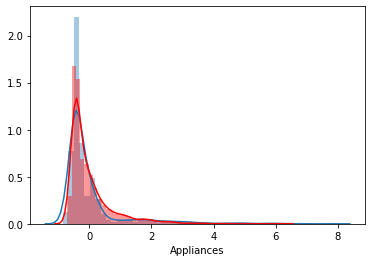

In [109]:
rf_prediction = rf.predict(X_test)
sns.distplot(Y_test)
sns.distplot(rf_prediction, color='red')

---

---

In [139]:
n_cores = 4
number_of_trees = 1000 # default = 100
X_trainWO = X_train.drop(["daytime"], axis=1)
X_testWO = X_test.drop(["daytime"], axis=1)
rf2 = RandomForestRegressor(n_jobs=n_cores, n_estimators=500, max_features=0.5, min_samples_leaf=1, oob_score=True, verbose=1)

rf2.fit(X_trainWO, Y_train)
print("Before:")
display(before)#
print("Now:")
before = print_score(rf2, X_trainWO, X_testWO, Y_train, Y_test)
print()
print("Feature importance")
print_RF_featureImportance(rf2, X_trainWO)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.5s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    8.8s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   18.6s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   21.0s finished


Before:


{'RMS(train)': 0.2510158817182229,
 'RMS(test)': 0.6589486112387508,
 'R2(train)': 0.9377351136687322,
 'R2(test)': 0.5439296250772873}

Now:


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.7s finished
[

{'RMS(train)': 0.24581638230418235,
 'RMS(test)': 0.639415420640861,
 'R2(train)': 0.9402878862350299,
 'R2(test)': 0.570567429881305}


Feature importance
lights: 0.04354		...  energy use of light fixtures in the house in Wh
T1: 0.03336		... Temperature in kitchen area: in Celsius
RH_1: 0.06172		...  Humidity in kitchen area: in %
T2: 0.04104		... Temperature in living room area: in Celsius
RH_2: 0.05120		...  Humidity in living room area: in %
T3: 0.05047		... Temperature in laundry room area
RH_3: 0.05161		... Humidity in laundry room area: in %
T4: 0.03669		... Temperature in office room: in Celsius
RH_4: 0.03922		... Humidity in office room: in %
T5: 0.03828		... Temperature in bathroom in Celsius
RH_5: 0.05160		... Humidity in bathroom in %
T6: 0.04000		... Temperature outside the building (north side: in Celsius
RH_6: 0.04636		... Humidity outside the building (north side): in %
T7: 0.03179		... Temperature in ironing room: in Celsius
RH_7: 0.04223		... Humidity in ironing room in %
T8: 0.04267		... Temperature in teenager room 2 in Celsius
RH_8: 0.05271		...  Humidity in teenager room 2 in %
T9: 0.03130		... Te

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.1s finished


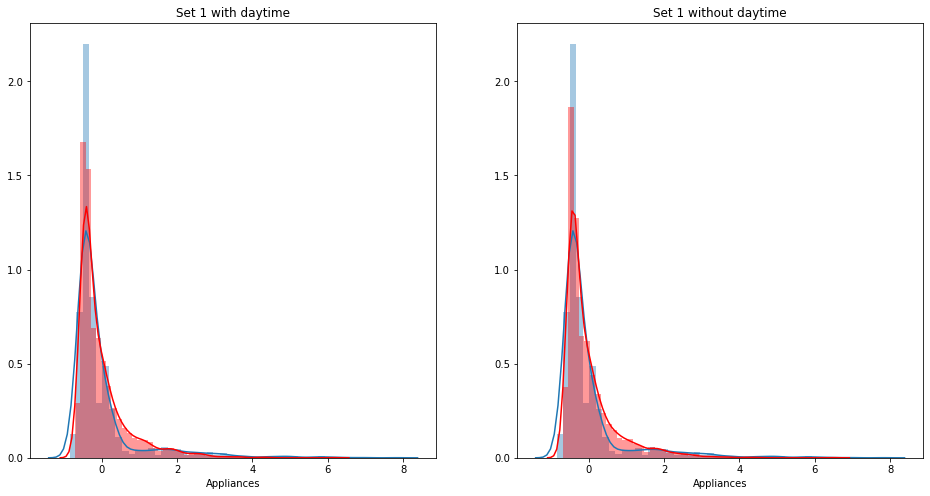

In [140]:
Y_rf_pred = rf.predict(X_test)
Y_rf_predWO = rf2.predict(X_testWO)
comp_between_sets(Y_rf_pred, Y_test, Y_rf_pred2, Y_test2, title1="Set 1 with daytime", title2="Set 1 without daytime", save=plot_dir+"dist_rfReg_dtvsnodt.png")

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.1s finished


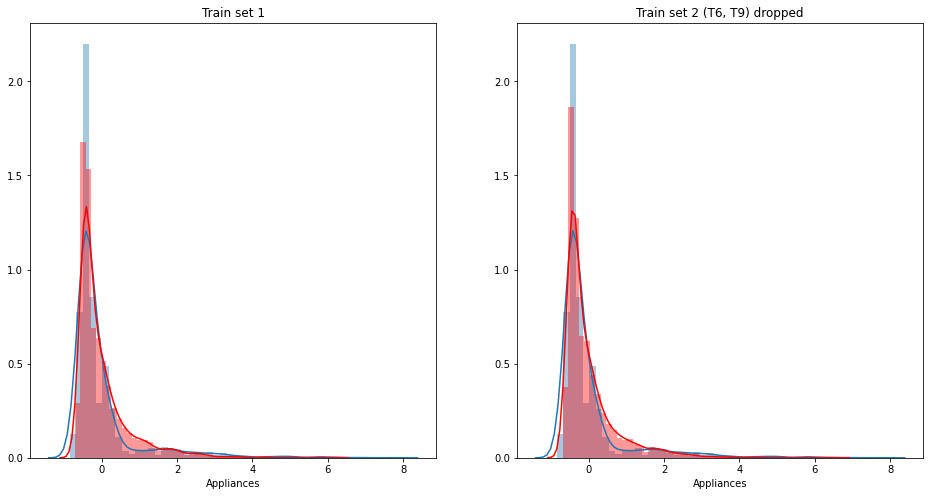

In [135]:
Y_rf_pred = rf.predict(X_test)
Y_rf_pred2 = rfSet2.predict(X_test2)
comp_between_sets(Y_rf_pred, Y_test, Y_rf_pred2, Y_test2, save=plot_dir+"dist_rfReg_S1+2.png")

In [142]:
# Save scores
print("Set 1")
rf_dict = dict()
print('rf1')
rf_dict['1'] = print_score(rf, X_train, X_test, Y_train, Y_test)
print("rf2")
rf_dict['2'] = print_score(rf2, X_trainWO, X_testWO, Y_train, Y_test)
model_scores['randomForest'] = rf_dict


rf_models = dict()
rf_models['1'] = rf
rf_models['2'] = rf2
models['randomForest'] = rf_models

print("Set 2")
# Set 2
model_scores2['randomForest'] = print_score(rfSet2, X_train2, X_test2, Y_train2, Y_test2)
models2['randomForest'] = rfSet2

rf1


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.6s finished
[

{'RMS(train)': 0.2428459669193612,
 'RMS(test)': 0.6334570066832834,
 'R2(train)': 0.9417222749625794,
 'R2(test)': 0.578533503576818}

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s


rf2


[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[

{'RMS(train)': 0.24581638230418235,
 'RMS(test)': 0.639415420640861,
 'R2(train)': 0.9402878862350299,
 'R2(test)': 0.570567429881305}

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s


Set 1
Set 2


[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[

{'RMS(train)': 0.242228031163464,
 'RMS(test)': 0.6381117464415833,
 'R2(train)': 0.9420184797820353,
 'R2(test)': 0.5723167447335177}

# Try different split of test/training data by time

In [129]:
print(f"Target={col_target}")
trainD, testD = preprocess_EnergySet(df_raw, split='days', train_size=0.8, scale=True)
X_trainD,Y_trainD = xy_split(trainD, target=col_target)
X_testD,Y_testD = xy_split(testD, target=col_target)
X_trainD

Target=Appliances
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19735 entries, 0 to 19734
Data columns (total 29 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         19735 non-null  datetime64[ns]
 1   Appliances   19735 non-null  int64         
 2   lights       19735 non-null  int64         
 3   T1           19735 non-null  float64       
 4   RH_1         19735 non-null  float64       
 5   T2           19735 non-null  float64       
 6   RH_2         19735 non-null  float64       
 7   T3           19735 non-null  float64       
 8   RH_3         19735 non-null  float64       
 9   T4           19735 non-null  float64       
 10  RH_4         19735 non-null  float64       
 11  T5           19735 non-null  float64       
 12  RH_5         19735 non-null  float64       
 13  T6           19735 non-null  float64       
 14  RH_6         19735 non-null  float64       
 15  T7           19735 non-null  float6

None

Dataset contains roughly: 137 days of data
Displaying DF before (optional) scaling and train/test splitting:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19735 entries, 0 to 19734
Data columns (total 25 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Appliances   19735 non-null  int64  
 1   lights       19735 non-null  int64  
 2   T1           19735 non-null  float64
 3   RH_1         19735 non-null  float64
 4   T2           19735 non-null  float64
 5   RH_2         19735 non-null  float64
 6   T3           19735 non-null  float64
 7   RH_3         19735 non-null  float64
 8   T4           19735 non-null  float64
 9   RH_4         19735 non-null  float64
 10  T5           19735 non-null  float64
 11  RH_5         19735 non-null  float64
 12  T6           19735 non-null  float64
 13  RH_6         19735 non-null  float64
 14  T7           19735 non-null  float64
 15  RH_7         19735 non-null  float64
 16  T8           19735 no

None

Number of rows: 19735
Number of columns in dataset is: 25


,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,...,RH_7,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,daytime
0,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,45.566667,...,41.626667,18.2,48.900000,17.033333,45.53,6.600000,733.5,92.0,7.000000,2
1,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,45.992500,...,41.560000,18.2,48.863333,17.066667,45.56,6.483333,733.6,92.0,6.666667,2
2,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,45.890000,...,41.433333,18.2,48.730000,17.000000,45.50,6.366667,733.7,92.0,6.333333,2
3,50,40,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,45.723333,...,41.290000,18.1,48.590000,17.000000,45.40,6.250000,733.8,92.0,6.000000,2
4,60,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,45.530000,...,41.230000,18.1,48.590000,17.000000,45.40,6.133333,733.9,92.0,5.666667,2


,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,...,RH_7,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,daytime
0,3.301264,-1.118645,1.843821,-0.520411,1.073683,-1.235063,1.686130,-0.908217,1.506438,-1.314903,...,1.219861,-1.957509,1.141572,-1.217324,0.958136,-0.152647,-2.976328,0.822080,1.207694,0.170171
1,3.301264,-1.118645,1.616807,-0.520411,1.057097,-1.235063,1.704566,-0.908217,1.604528,-1.314903,...,1.206825,-1.957509,1.134554,-1.200778,0.965363,-0.174588,-2.962813,0.822080,1.071703,0.170171
2,3.301264,-1.118645,1.517959,-0.520411,1.033550,-1.235063,1.748608,-0.944115,1.580918,-1.314903,...,1.182057,-1.957509,1.109032,-1.233869,0.950910,-0.196529,-2.949298,0.822080,0.935713,0.170171
3,4.561378,-1.118645,1.459321,-0.520411,1.024540,-1.235063,1.769092,-0.962063,1.542526,-1.314903,...,1.154030,-2.008631,1.082233,-1.233869,0.926821,-0.218470,-2.935783,0.822080,0.799723,0.170171
4,4.561378,-1.118645,1.526336,-0.520411,1.009797,-1.235063,1.769092,-0.962063,1.497991,-1.296832,...,1.142298,-2.008631,1.082233,-1.233869,0.926821,-0.240411,-2.922268,0.822080,0.663733,0.170171
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15783,-0.479080,-0.246927,-0.752180,-0.707377,-0.005018,0.260406,-0.627594,-0.766257,-0.330991,-0.266786,...,-0.351618,-0.377845,0.330607,-0.141874,-0.006199,-0.434746,0.314545,1.090524,-1.240129,-1.464050
15784,-0.479080,-0.205417,-0.653332,-0.661776,0.041669,0.230496,-0.711580,-0.795628,-0.300278,-0.302928,...,-0.344448,-0.377845,0.316570,-0.141874,-0.020652,-0.415940,0.325807,1.068154,-1.240129,-1.464050
15785,-0.479080,-0.184662,-0.580453,-0.628335,0.026926,0.165692,-0.863165,-0.766257,-0.106016,-0.266786,...,-0.318376,-0.423854,0.285944,-0.141874,-0.036711,-0.397133,0.337070,1.045783,-1.240129,-1.464050
15786,-0.479080,-0.184662,-0.567888,-0.611614,-0.032047,0.165692,-0.824245,-0.766257,-0.075302,-0.230644,...,-0.305340,-0.423854,0.247660,-0.141874,-0.093720,-0.378326,0.348332,1.023413,-1.240129,-1.464050


In [130]:
n_cores = 4

linreg_new = LinearRegression(normalize = True, n_jobs=n_cores)
lasso_new = Lasso(normalize = False, alpha=1e-6, max_iter=2000)
kNN_new = neighbors.KNeighborsRegressor(n_neighbors=2, n_jobs=n_cores)
rf_new = RandomForestRegressor(n_jobs=n_cores, n_estimators=500, max_features='sqrt')
new_models = [linreg_new, lasso_new, kNN_new, rf_new]
new_scores = []
for newModel, modelName in zip(new_models, ['linReg', 'lassoReg', 'kNN', 'randomForest']):
    print(modelName)
    newModel.fit(X_trainD, Y_trainD)
    score = print_score(newModel, X_trainD, X_testD, Y_trainD, Y_testD)
    new_scores.append(score)
    print('-'*40)

linReg


{'RMS(train)': 0.9217444517882036,
 'RMS(test)': 0.8373579041649579,
 'R2(train)': 0.19301060203644926,
 'R2(test)': 0.11078168941700262}

----------------------------------------
lassoReg


{'RMS(train)': 0.9217444521022775,
 'RMS(test)': 0.8373581394713303,
 'R2(train)': 0.1930106014865045,
 'R2(test)': 0.1107811896575489}

----------------------------------------
kNN


{'RMS(train)': 0.4013329472628531,
 'RMS(test)': 1.38611594299174,
 'R2(train)': 0.8470123429455217,
 'R2(test)': -1.436605758404053}

----------------------------------------
randomForest


{'RMS(train)': 0.22791451033431767,
 'RMS(test)': 1.728303827234792,
 'R2(train)': 0.9506609575980075,
 'R2(test)': -2.788142712590631}

----------------------------------------


# Conclusio

The linear and lasso regression are pretty much uneffected by the different split.

However, the kNN and random forest models seem to overfit the training data when giving split into this straight forward way as indicated by the huge drop in the RMS and R2 score when going from the training to the test set!

In [144]:
model_scores

{'linReg': {'RMS(train)': 0.9091848811402113,
  'RMS(test)': 0.8791985912456376,
  'R2(train)': 0.18314455200158364,
  'R2(test)': 0.1880996369544411},
 'lassoReg': {'RMS(train)': 0.9091848814383682,
  'RMS(test)': 0.8791979841629626,
  'R2(train)': 0.18314455146582664,
  'R2(test)': 0.1881007581811559},
 'kNN': {'p2_k2': {'RMS(train)': 0.4042780730865147,
   'RMS(test)': 0.6941401902798184,
   'R2(train)': 0.8384893467936548,
   'R2(test)': 0.49391536797945856}},
 'randomForest': {'1': {'RMS(train)': 0.2428459669193612,
   'RMS(test)': 0.6334570066832834,
   'R2(train)': 0.9417222749625794,
   'R2(test)': 0.578533503576818},
  '2': {'RMS(train)': 0.24581638230418235,
   'RMS(test)': 0.639415420640861,
   'R2(train)': 0.9402878862350299,
   'R2(test)': 0.570567429881305}}}